<img src="https://raw.githubusercontent.com/brazil-data-cube/jupyter-gallery/master/img/logo-bdc.png" align="right" width="64"/>

# <span style="color:#336699"> Web Time Series Service (WTSS) R client - Example</span>
<hr style="border:2px solid #0077b9;">

## 1. Importing the packages <a id="sec-1-2"></a>

In [1]:
# require package
if (!requireNamespace("remotes", quietly = TRUE)) {
    print("Installing remotes package")    
    install.packages("remotes")
}

# installing wtss package
remotes::install_github("e-sensing/Rwtss", upgrade = "never")

If you are not using the kaggle environment, please install the packages listed below:

In [19]:
# Checking if the required packages are installed, if not the installation is done
print("Checking if the necessary packages are available...")
install.packages(setdiff(c("magrittr", "dplyr", "tibble", "tidyr"), rownames(installed.packages())), quiet = TRUE)

In [18]:
library(Rwtss)    # Package Rwtss
library(magrittr) # Package to use pipe operator %>%
library(dplyr)    # Package to handle with data frame
library(tibble)   # Package to represent data frame structure
library(tidyr)    # Package to transform data frame structure

Before we start, let's create a variable that corresponds to the URL of the INPE WTSS service.

In [4]:
wtss_inpe <- "https://brazildatacube.dpi.inpe.br/esensing/wtss"

# 2. Retrieving the Time Series
<hr style="border:1px solid #0077b9;">

Let's create a tibble of samples to extract their time series.

In [5]:
points <- tibble::tibble(longitude = c(-46.197, -45.666, -45.893,
                                       -46.536, -46.545, -46.548,
                                       -45.953, -45.627, -45.265),
                         latitude  = c(-12.434, -12.461, -12.662,
                                       -12.306, -12.310, -12.317,
                                       -12.840, -13.157, -12.292),
                         label     = c("Crop", "Crop", "Crop",
                                       "Pasture", "Pasture", "Pasture",
                                       "Cerradao", "Cerradao", "Cerradao"))

points

longitude,latitude,label
<dbl>,<dbl>,<chr>
-46.197,-12.434,Crop
-45.666,-12.461,Crop
-45.893,-12.662,Crop
-46.536,-12.306,Pasture
-46.545,-12.310,Pasture
-46.548,-12.317,Pasture
-45.953,-12.840,Cerradao
-45.627,-13.157,Cerradao
-45.265,-12.292,Cerradao


Thus, let's extract the time series of each sample from our tibble created.

In [6]:
tibble_ts <- list()

for(i in seq_len(nrow(points))) {
       
    time_series <- Rwtss::time_series(wtss_inpe,
                                      attributes = c("ndvi", "evi"), 
                                      latitude   = points[i,]$latitude, 
                                      longitude  = points[i,]$longitude,
                                      name       = "MOD13Q1",
                                      start_date = "2018-08-01",
                                      end_date   = "2019-09-01")
    
    tibble_ts[i] <- list(time_series)
}

tibble_ts <- dplyr::bind_rows(tibble_ts)

Finally, let's add the labels to our time series tibble.

In [7]:
tibble_ts <- tibble_ts %>% dplyr::mutate(id    = 1:nrow(tibble_ts),
                                         label = factor(points$label))

# 2. Time series plots
<hr style="border:1px solid #0077b9;">

Let's create different plots to present our time series, they are variants of the parallel coordinate plot. First, let's start creating a function to transform our tibble in long format. For more, see [Converting data between wide and long format](http://www.cookbook-r.com/Manipulating_data/Converting_data_between_wide_and_long_format/).

In [8]:
#' @description This function transforms a wide tibble to long format
#' @param wtss_ts a tibble retrived from wtss time series function
#' @param ...     columns to add or remove in long form
#' @return a tibble in long format
wide2long <- function(wtss_ts, ...) {
     
     if (!"wtss" %in% class(wtss_ts))
         stop("Provide a wtss time series pattern.")
     
    wtss_ts <- wtss_ts %>% 
     dplyr::group_by(longitude,
                     latitude,
                     start_date,
                     end_date,
                     label,
                     cube) %>%
     tidyr::unnest(cols = c(time_series)) %>% 
     tidyr::gather(indice, valor, -longitude:-Index, -id, ...)
     
     return(wtss_ts)
 } 

In order to create our plots, we will use `ggplot` package and its complementary packages. So, if you do not have these packages, you can install them using the command in below cell. 

In [20]:
# Checking if the required packages are installed, if not the installation is done
print("Checking if the necessary packages are available...")
install.packages(setdiff(c("ggplot2", "scales", "cowplot"), rownames(installed.packages())), quiet = TRUE)

In [10]:
library(ggplot2)
library(scales)
library(cowplot)

theme_set(theme_cowplot())

Now, lets create a simple greyscale plot based on parallel coordinate. 

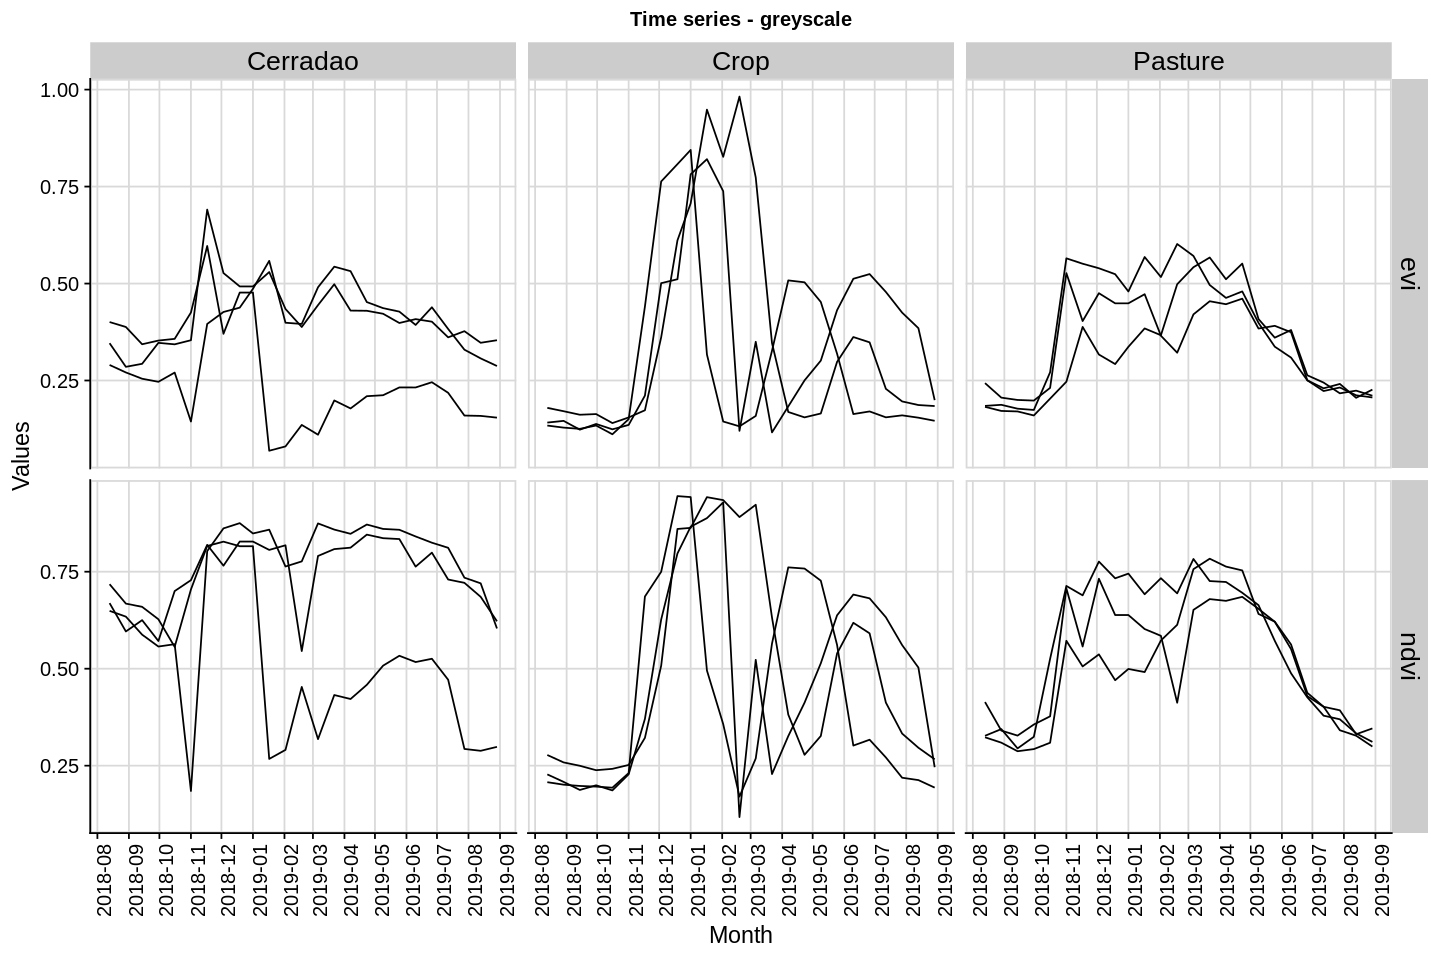

In [11]:
options(repr.plot.width=12, repr.plot.height=8)


tibble_ts %>% wide2long %>%
ggplot(aes(x=Index,y= valor, group = id)) +
    geom_line() + 
    facet_grid(indice ~ label, scales = "free", space = "free") +
    scale_x_date(name="Month",labels = date_format("%Y-%m"),
               breaks='1 month')  + 
    theme(strip.text.x = element_text(size = 16, colour = "black"),
        strip.text.y = element_text(size = 16, colour = "black"),
        plot.title = element_text(size = 12,
                                  hjust= 0.5,
                                  margin = margin(b = 7)),
        axis.text.x = element_text(angle = 90,
                                   hjust=-0.5),
        #strip.background = element_blank(),
        legend.position="right",
        legend.text = element_text(size = 11)) +
        labs(title = "Time series - greyscale",
             y = "Values") + 
    guides(colour = guide_legend(nrow = 3, override.aes = list(size = 2))) +
    scale_color_manual(name = "Labels: ",
                     labels = c("Cerradão",
                                "Crop",
                                "Pasture"),
                     values = c("#a1dd70",
                                "#ffd319",
                                "#ff0000")) + 
 panel_border() +
  background_grid()

But, to better visualization, lets add different colors to each time series.

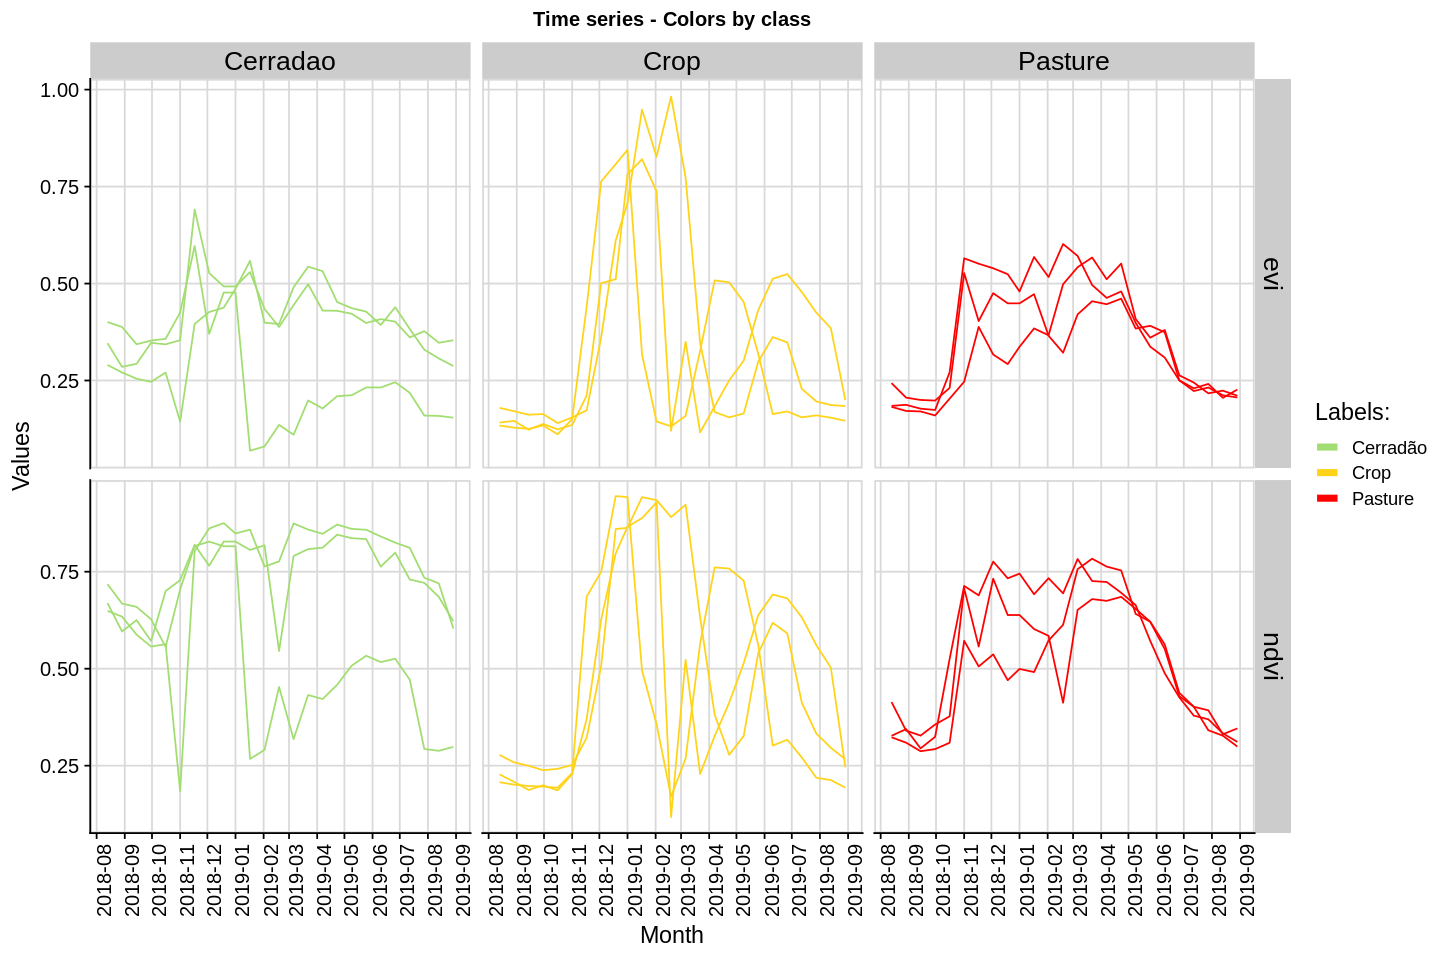

In [12]:
options(repr.plot.width=12, repr.plot.height=8)

tibble_ts %>% wide2long() %>%
ggplot(aes(x=Index,y= valor, group = id, color = label)) +
    geom_line() + 
    facet_grid(indice ~ label, scales = "free", space = "free") +
    scale_x_date(name="Month",labels = date_format("%Y-%m"),
               breaks='1 month')  + 
    theme(strip.text.x = element_text(size = 16, colour = "black"),
        strip.text.y = element_text(size = 16, colour = "black"),
        plot.title = element_text(size = 12,
                                  hjust= 0.5,
                                  margin = margin(b = 7)),
        axis.text.x = element_text(angle = 90,
                                   hjust=-0.5),
        legend.position="right",
        legend.text = element_text(size = 11)) +
        labs(title = "Time series - Colors by class",
             y = "Values") + 
    guides(colour = guide_legend(nrow = 3, override.aes = list(size = 2))) +
    scale_color_manual(name = "Labels: ",
                     labels = c("Cerradão",
                                "Crop",
                                "Pasture"),
                     values = c("#a1dd70" ,
                                "#ffd319",
                                "#ff0000")) +  
    panel_border() +
    background_grid()

To extract more information of the patterns to each class, we can add some statical measure in it. In above example, its presented a plot based on mean value of each class.

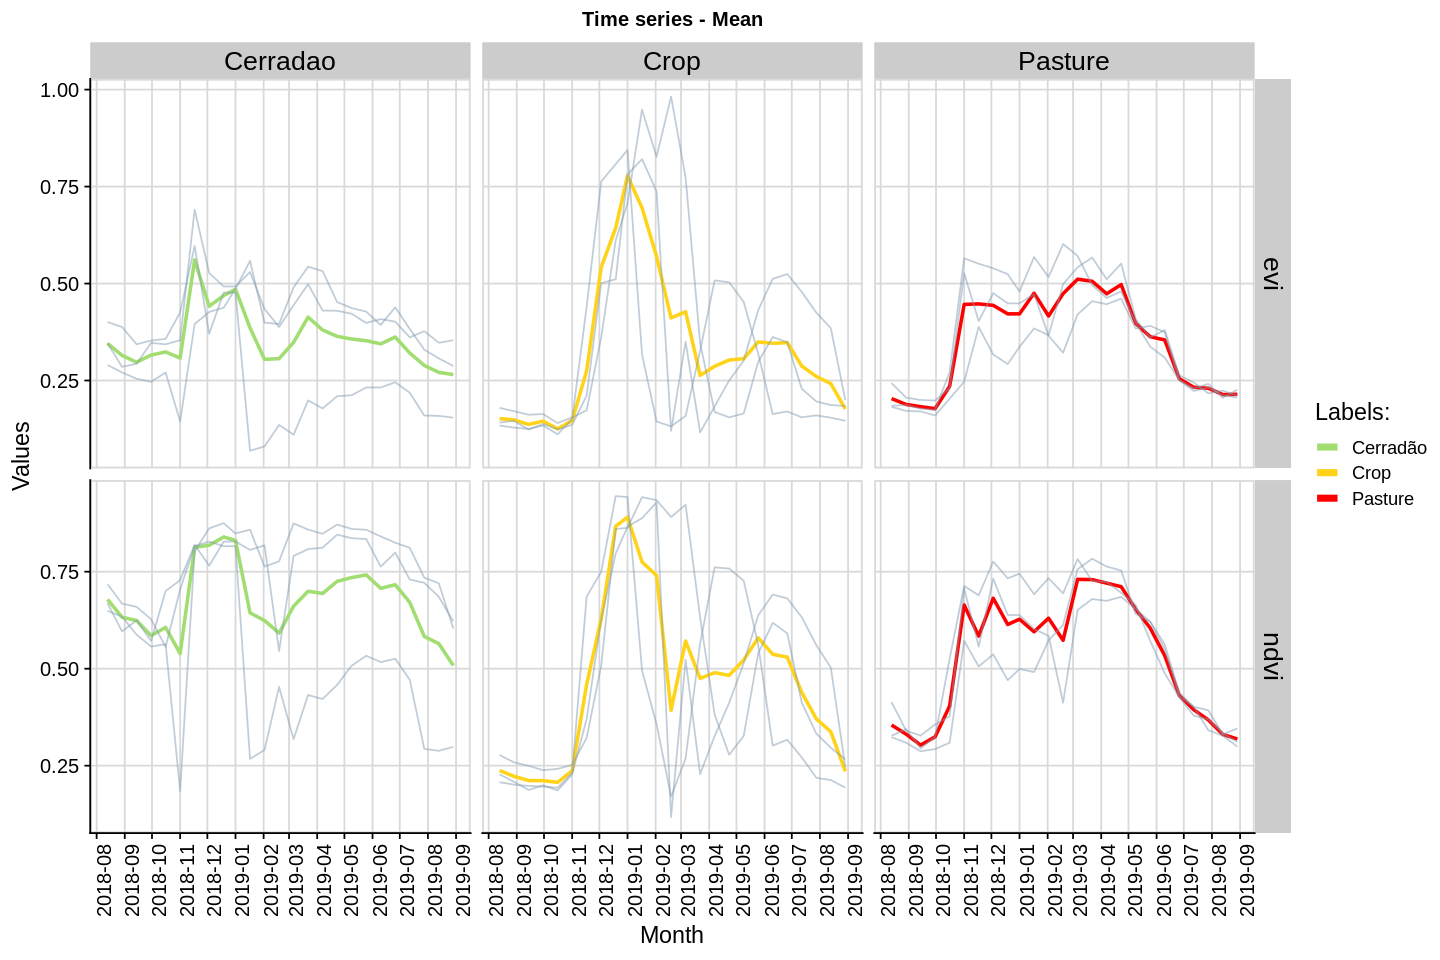

In [13]:
tibble_ts %>% wide2long %>%
ggplot(aes(x=Index,y= valor, group = id)) +
    stat_summary(fun = "mean", geom = "smooth", size = 1, aes(colour = label, group = label)) +
    geom_line(colour = "#819BB1", alpha = 0.5) + 
    facet_grid(indice ~ label, scales = "free", space = "free") +
    scale_x_date(name="Month",labels = date_format("%Y-%m"),
               breaks='1 month')  + 
    theme(strip.text.x = element_text(size = 16, colour = "black"),
        strip.text.y = element_text(size = 16, colour = "black"),
        plot.title = element_text(size = 12,
                                  hjust= 0.5,
                                  margin = margin(b = 7)),
        axis.text.x = element_text(angle = 90,
                                   hjust=-0.5),
        legend.position="right",
        legend.text = element_text(size = 11)) +
        labs(title = "Time series - Mean",
             y = "Values") + 
    guides(colour = guide_legend(nrow = 3, override.aes = list(size = 2))) +
    scale_color_manual(name = "Labels: ",
                     labels = c("Cerradão",
                                "Crop",
                                "Pasture"),
                     values = c("#a1dd70" ,
                                "#ffd319",
                                "#ff0000")) + 
    panel_border() +
    background_grid()

# 3. Smoothing time series
<hr style="border:1px solid #0077b9;">

Now, let's see an example of how to apply a smoothing filter to our extracted time series. Firstly, its necessary to install `signal` to use sav-golay filter.

In [21]:
# Checking if the required packages are installed, if not the installation is done
print("Checking if the necessary packages are available...")
install.packages(setdiff("signal", rownames(installed.packages())), quiet = TRUE)

In [22]:
# importing signal package
library(signal)

Let's add each smooth series within our time series list, as presented in the cell below

In [16]:
# lets add to other variable
tibble_ts_smoothed <- tibble_ts

for(i in seq_len(nrow(tibble_ts_smoothed))) {
       
    tibble_ts_smoothed[i,]$time_series[[1]] <- tibble_ts_smoothed[i,]$time_series[[1]] %>% 
                                                 dplyr::mutate(smooth_ndvi = signal::sgolayfilt(ndvi, n = 7),
                                                               smooth_evi  = signal::sgolayfilt(evi, n = 7))
}

Let's create a plot that presents our smoothed time series and our original time series.

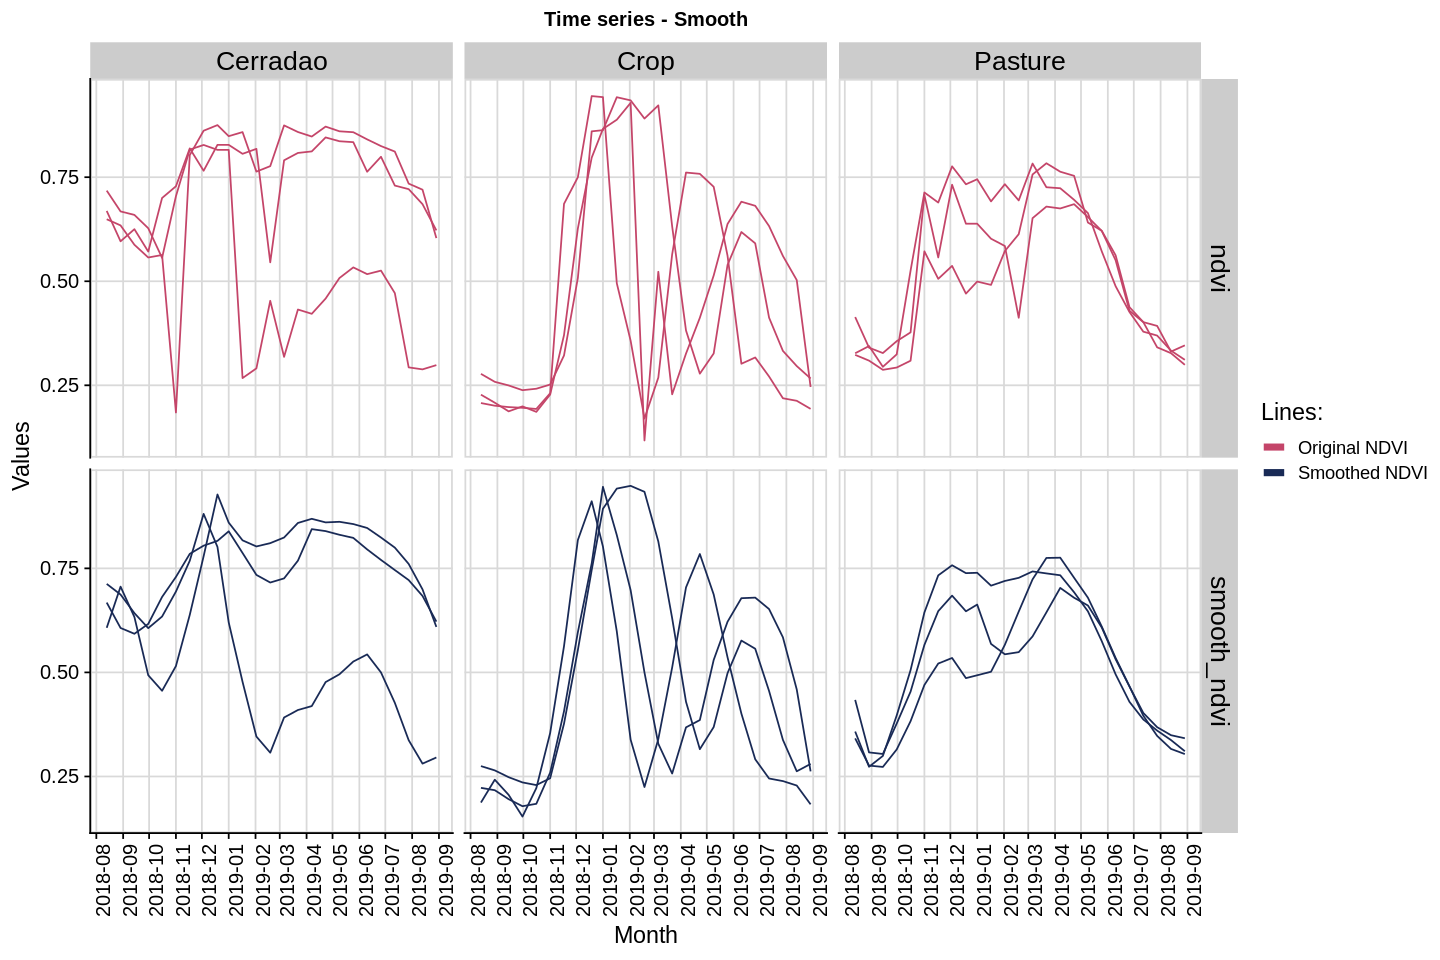

In [17]:
tibble_ts_smoothed %>% wide2long(-evi, -smooth_evi) %>%
ggplot(aes(x = Index, y = valor, group = id)) +
    geom_line(aes(colour = indice), alpha = 1, ) + 
    facet_grid(indice ~ label, scales = "free", space = "free") +
    scale_x_date(name = "Month",labels = date_format("%Y-%m"),
               breaks = '1 month')  + 
    theme(strip.text.x = element_text(size = 16, colour = "black"),
        strip.text.y = element_text(size = 16, colour = "black"),
        plot.title = element_text(size = 12,
                                  hjust = 0.5,
                                  margin = margin(b = 7)),
        axis.text.x = element_text(angle = 90,
                                   hjust = -0.5),
        legend.position="right",
        legend.text = element_text(size = 11)) +
        labs(title = "Time series - Smooth",
             y = "Values") + 
    guides(colour = guide_legend(nrow = 3, override.aes = list(size = 2))) +
    scale_color_manual(name = "Lines: ",
                     labels = c("Original NDVI",
                                "Smoothed NDVI"),
                     values = c("#c44569" ,
                                "#192a56")) + 
    panel_border() +
    background_grid()

# 4. References
<hr style="border:1px solid #0077b9;">

- [R Client Library for Web Time Series Service - Github Repository](https://github.com/e-sensing/wtss)


- [WTSS OpenAPI 3 Specification](https://github.com/brazil-data-cube/wtss-spec)


- [WTSS Server](https://github.com/brazil-data-cube/wtss)


- VINHAS, L.; QUEIROZ, G. R.; FERREIRA, K. R.; CÂMARA, G. [Web Services for Big Earth Observation Data](http://www.seer.ufu.br/index.php/revistabrasileiracartografia/article/view/44004). Revista Brasileira de Cartografia, v. 69, n. 5, 18 maio 2017.